In [52]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt


In [53]:
pip install  yfinance

Note: you may need to restart the kernel to use updated packages.


In [54]:
import yfinance as yf

market_data = yf.download('^IXIC', start='2022-03-01', end='2024-08-21')
tsla_data = yf.download('TSLA', start='2022-03-01', end='2024-08-21')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [55]:
tsla_data.reset_index(inplace=True)
market_data.reset_index(inplace=True)

In [57]:
market_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-03-01,13716.700195,13777.040039,13441.320312,13532.459961,13532.459961,6131350000
1,2022-03-02,13597.530273,13796.549805,13493.910156,13752.019531,13752.019531,5246390000
2,2022-03-03,13837.589844,13837.589844,13472.639648,13537.940430,13537.940430,5092580000
3,2022-03-04,13455.230469,13486.709961,13224.980469,13313.440430,13313.440430,5343900000
4,2022-03-07,13328.360352,13353.280273,12828.019531,12830.959961,12830.959961,6195370000
...,...,...,...,...,...,...,...
617,2024-08-14,17227.640625,17260.730469,17032.169922,17192.599609,17192.599609,4985480000
618,2024-08-15,17394.539062,17602.720703,17375.410156,17594.500000,17594.500000,5478170000
619,2024-08-16,17516.400391,17674.650391,17502.830078,17631.720703,17631.720703,5138150000
620,2024-08-19,17649.740234,17877.439453,17585.580078,17876.769531,17876.769531,5564300000


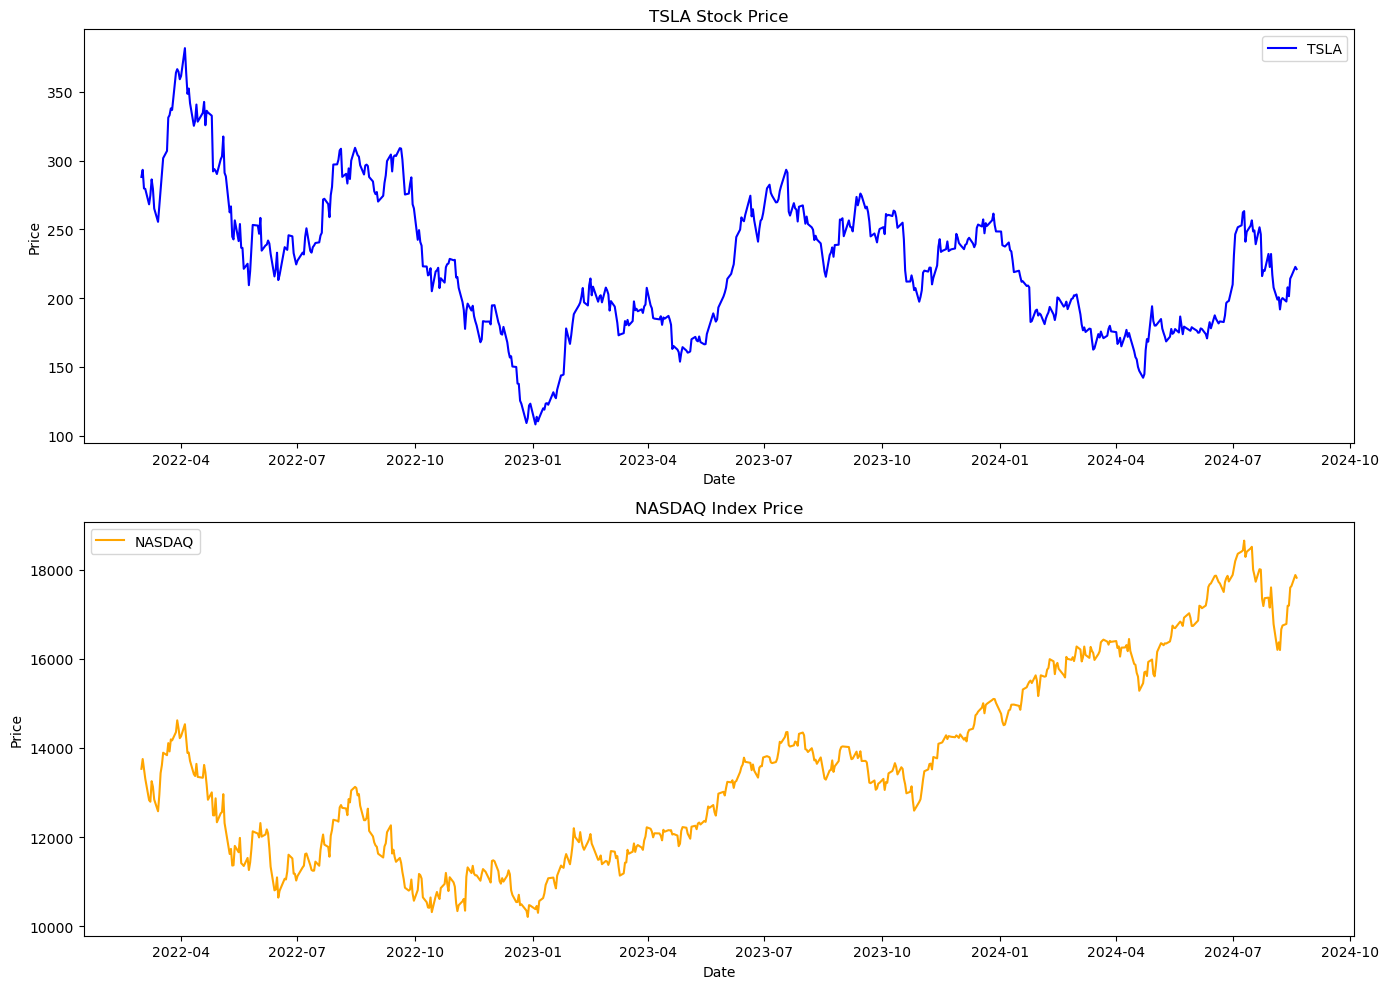

In [58]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1) 
plt.plot(tsla_data['Date'], tsla_data['Close'], label='TSLA', color='blue')
plt.title('TSLA Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.subplot(2, 1, 2)  
plt.plot(market_data['Date'], market_data['Close'], label='NASDAQ', color='orange')
plt.title('NASDAQ Index Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()  
plt.show()

In [60]:
tsla_data['Date'] = pd.to_datetime(tsla_data['Date'])
market_data['Date'] = pd.to_datetime(market_data['Date'])

In [61]:
#tsla_data.set_index('Date', inplace=True)
#market_data.set_index('Date', inplace=True)

In [62]:
market_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-03-01,13716.700195,13777.040039,13441.320312,13532.459961,13532.459961,6131350000
1,2022-03-02,13597.530273,13796.549805,13493.910156,13752.019531,13752.019531,5246390000
2,2022-03-03,13837.589844,13837.589844,13472.639648,13537.940430,13537.940430,5092580000
3,2022-03-04,13455.230469,13486.709961,13224.980469,13313.440430,13313.440430,5343900000
4,2022-03-07,13328.360352,13353.280273,12828.019531,12830.959961,12830.959961,6195370000
...,...,...,...,...,...,...,...
617,2024-08-14,17227.640625,17260.730469,17032.169922,17192.599609,17192.599609,4985480000
618,2024-08-15,17394.539062,17602.720703,17375.410156,17594.500000,17594.500000,5478170000
619,2024-08-16,17516.400391,17674.650391,17502.830078,17631.720703,17631.720703,5138150000
620,2024-08-19,17649.740234,17877.439453,17585.580078,17876.769531,17876.769531,5564300000


In [63]:
data = pd.merge(tsla_data[['Date', 'Close']], market_data[['Date', 'Close']], on='Date', suffixes=('_TSLA', '_Market'))
data.set_index('Date', inplace=True)

In [64]:
features = data[['Close_TSLA', 'Close_Market']]

In [65]:
model = IsolationForest(contamination=0.15)  
data['anomaly'] = model.fit_predict(features)

In [66]:
data['anomaly'] = np.where(data['anomaly'] == -1, 1, 0)

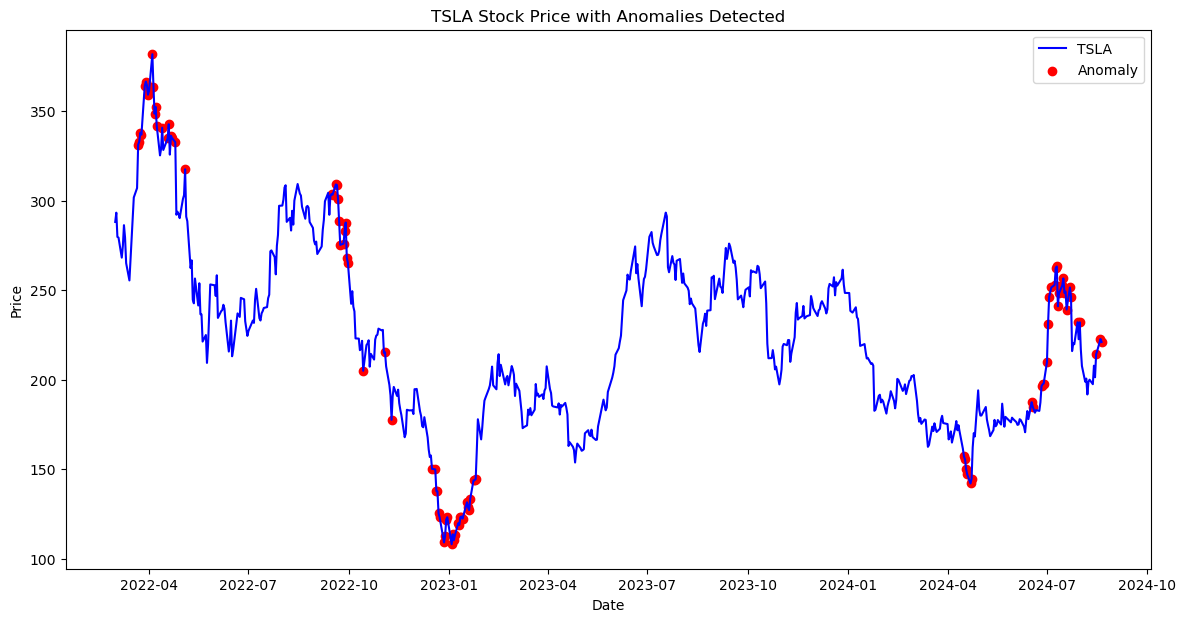

In [67]:
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close_TSLA'], label='TSLA', color='blue')
plt.scatter(data[data['anomaly'] == 1].index, data[data['anomaly'] == 1]['Close_TSLA'], color='red', label='Anomaly', marker='o')
plt.title('TSLA Stock Price with Anomalies Detected')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

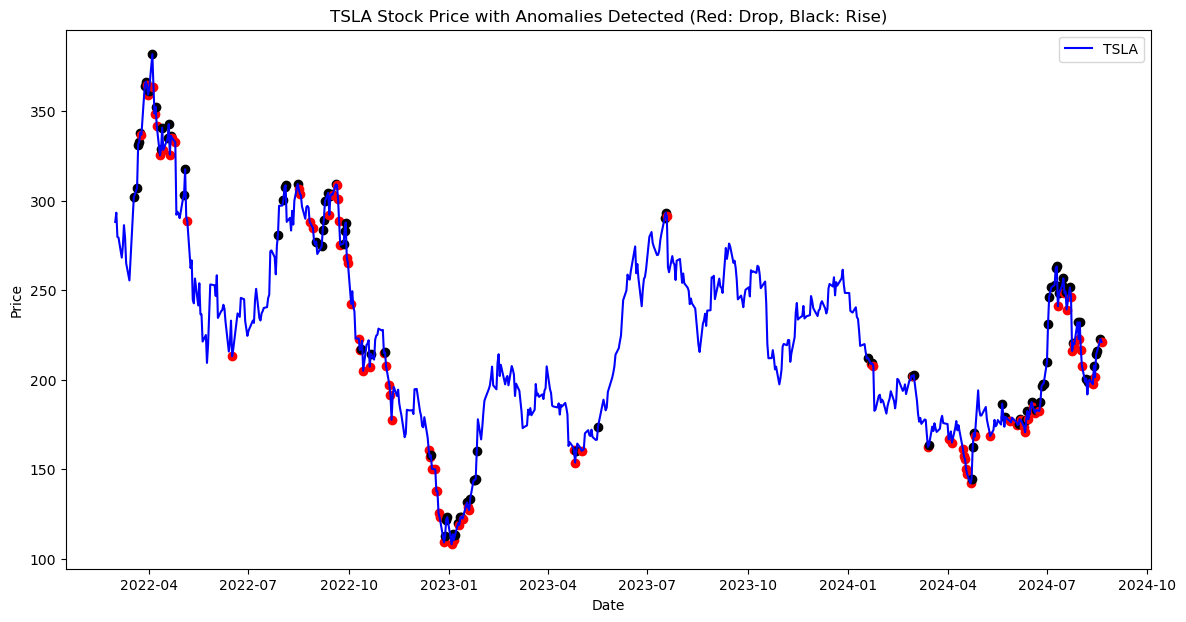

In [68]:
model = IsolationForest(contamination=0.3) 
data['anomaly'] = model.fit_predict(features)

data['anomaly'] = np.where(data['anomaly'] == -1, 1, 0)

data['percentage_change'] = data['Close_TSLA'].pct_change() * 100  

plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close_TSLA'], label='TSLA', color='blue')

for i in range(len(data)):
    if data['anomaly'].iloc[i] == 1:  
        if data['percentage_change'].iloc[i] < 0:  # 跌
            plt.scatter(data.index[i], data['Close_TSLA'].iloc[i], color='red', marker='o')
        elif data['percentage_change'].iloc[i] > 0:  # 涨
            plt.scatter(data.index[i], data['Close_TSLA'].iloc[i], color='black', marker='o')

plt.title('TSLA Stock Price with Anomalies Detected (Red: Drop, Black: Rise)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [69]:
tsla_data.set_index('Date', inplace=True)
market_data.set_index('Date', inplace=True)

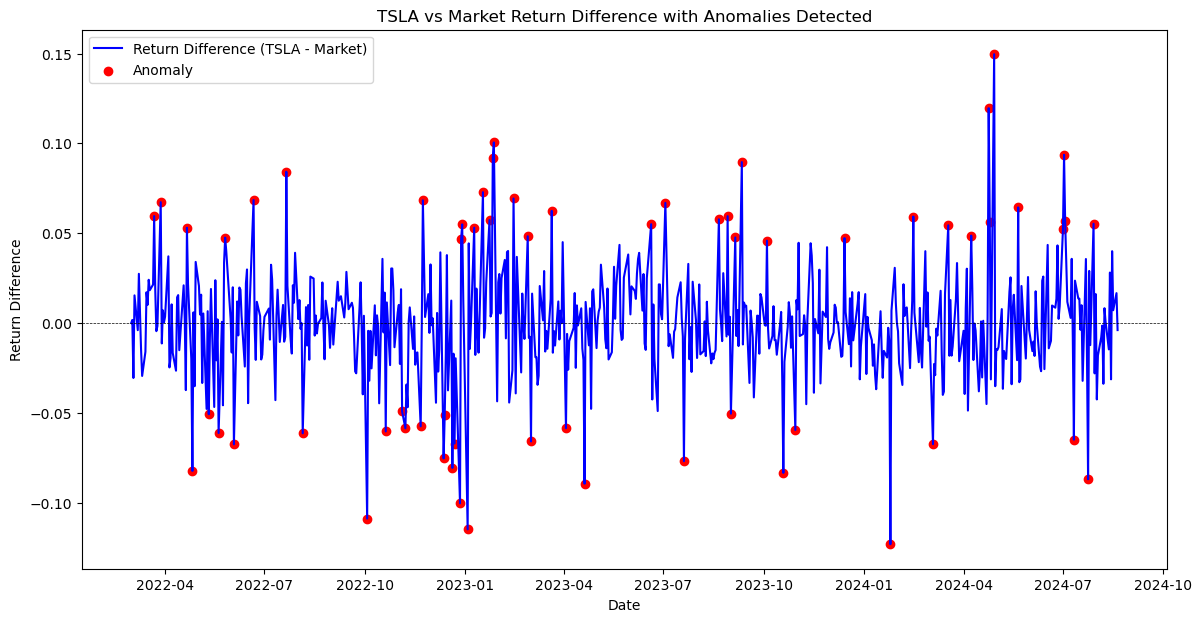

In [71]:
tsla_data['Return'] = tsla_data['Close'].pct_change()  
market_data['Return'] = market_data['Close'].pct_change()  

returns_data = pd.merge(tsla_data[['Return']], market_data[['Return']], left_index=True, right_index=True, suffixes=('_TSLA', '_Market'))

#returns_data.reset_index(inplace=True)

returns_data['Return_Difference'] = returns_data['Return_TSLA'] - returns_data['Return_Market']

returns_data.fillna(0, inplace=True)

model = IsolationForest(contamination=0.1) 
returns_data['anomaly'] = model.fit_predict(returns_data[['Return_Difference']])

returns_data['anomaly'] = np.where(returns_data['anomaly'] == -1, 1, 0)


plt.figure(figsize=(14, 7))
plt.plot(returns_data.index, returns_data['Return_Difference'], label='Return Difference (TSLA - Market)', color='blue')
plt.scatter(returns_data[returns_data['anomaly'] == 1].index, returns_data[returns_data['anomaly'] == 1]['Return_Difference'], color='red', label='Anomaly', marker='o')
plt.title('TSLA vs Market Return Difference with Anomalies Detected')
plt.xlabel('Date')
plt.ylabel('Return Difference')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')  # 添加零线
plt.legend()
plt.show()

In [72]:

returns_data

,Return_TSLA,Return_Market,Return_Difference,anomaly
Date,,,,
2022-03-01,0.000000,0.000000,0.000000,0
2022-03-02,0.017955,0.016225,0.001731,0
2022-03-03,-0.046142,-0.015567,-0.030575,0
2022-03-04,-0.001192,-0.016583,0.015392,0
2022-03-07,-0.040213,-0.036240,-0.003973,0
...,...,...,...,...
2024-08-14,-0.031035,0.000290,-0.031325,0
2024-08-15,0.063363,0.023376,0.039986,0
2024-08-16,0.009246,0.002115,0.007131,0


In [73]:
tsla_data['Return'] = tsla_data['Close'].pct_change()  
market_data['Return'] = market_data['Close'].pct_change()  

In [74]:
returns_data

,Return_TSLA,Return_Market,Return_Difference,anomaly
Date,,,,
2022-03-01,0.000000,0.000000,0.000000,0
2022-03-02,0.017955,0.016225,0.001731,0
2022-03-03,-0.046142,-0.015567,-0.030575,0
2022-03-04,-0.001192,-0.016583,0.015392,0
2022-03-07,-0.040213,-0.036240,-0.003973,0
...,...,...,...,...
2024-08-14,-0.031035,0.000290,-0.031325,0
2024-08-15,0.063363,0.023376,0.039986,0
2024-08-16,0.009246,0.002115,0.007131,0


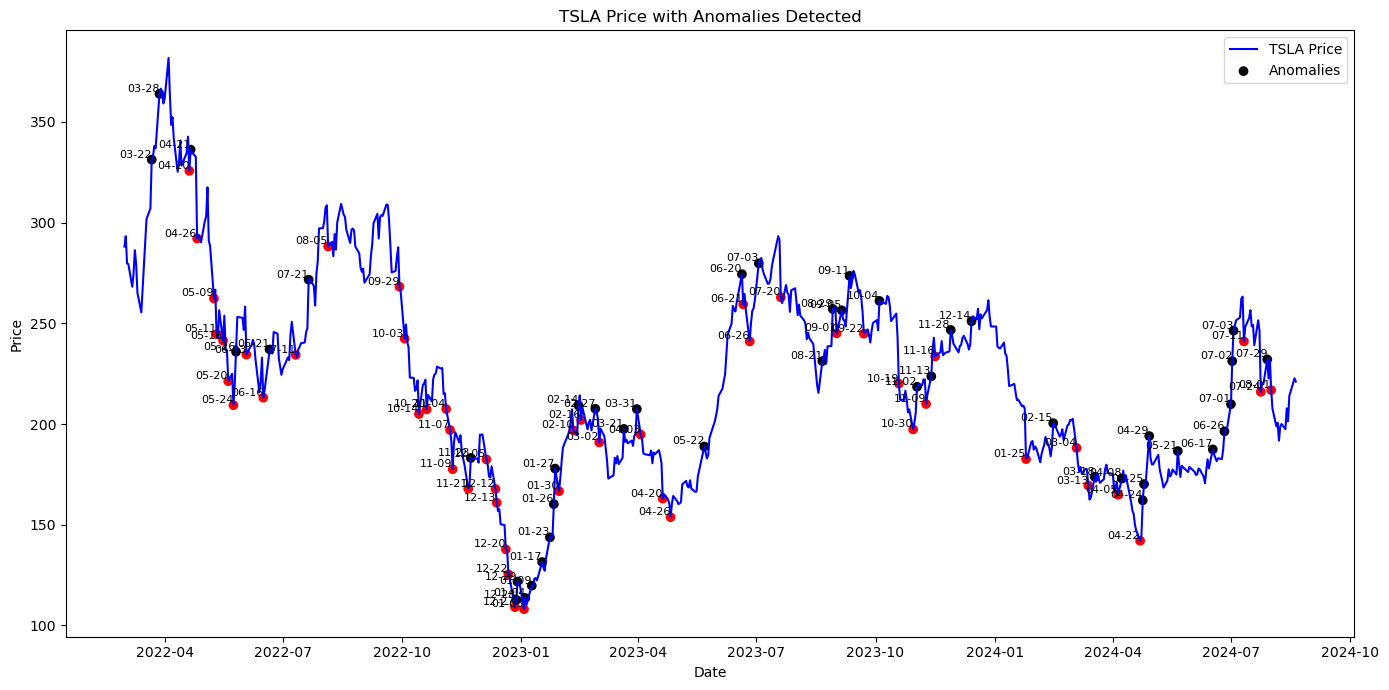

In [75]:
model = IsolationForest(contamination=0.15) 
returns_data['anomaly'] = model.fit_predict(returns_data[['Return_Difference']])

returns_data['anomaly'] = np.where(returns_data['anomaly'] == -1, 1, 0)

returns_data['anomaly_color'] = np.where(returns_data['Return_Difference'] < 0, 'red', 'black')

plt.figure(figsize=(14, 7))

plt.plot(tsla_data.index, tsla_data['Close'], label='TSLA Price', color='blue')

anomaly_indices = returns_data[returns_data['anomaly'] == 1].index
plt.scatter(anomaly_indices, tsla_data.loc[anomaly_indices]['Close'], 
            color=returns_data.loc[anomaly_indices]['anomaly_color'], label='Anomalies', marker='o')

for index in anomaly_indices:
    plt.text(index, tsla_data.loc[index]['Close'], 
             index.strftime('%m-%d'), 
             fontsize=8, 
             ha='right', 
             va='bottom')

plt.title('TSLA Price with Anomalies Detected')
plt.xlabel('Date')  
plt.ylabel('Price')
plt.legend()
#plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()

In [76]:
returns_data.loc[(returns_data['anomaly'] == 1) & (returns_data['Return_Difference'] > 0), 'anomaly'] = 0

In [77]:
#returns_data.loc[(returns_data['anomaly'] == 1) & (returns_data['Return_Difference'] < 0), 'anomaly'] = 0

In [78]:
returns_data.to_csv('C:/Users/Hioku/图形/returns_data.csv', index=False)

In [79]:
returns_data

,Return_TSLA,Return_Market,Return_Difference,anomaly,anomaly_color
Date,,,,,
2022-03-01,0.000000,0.000000,0.000000,0,black
2022-03-02,0.017955,0.016225,0.001731,0,black
2022-03-03,-0.046142,-0.015567,-0.030575,0,red
2022-03-04,-0.001192,-0.016583,0.015392,0,black
2022-03-07,-0.040213,-0.036240,-0.003973,0,red
...,...,...,...,...,...
2024-08-14,-0.031035,0.000290,-0.031325,0,red
2024-08-15,0.063363,0.023376,0.039986,0,black
2024-08-16,0.009246,0.002115,0.007131,0,black


In [80]:
returns_data_filtered=returns_data[returns_data.index <= '2024-03-31']

In [81]:
returns_data_filtered

,Return_TSLA,Return_Market,Return_Difference,anomaly,anomaly_color
Date,,,,,
2022-03-01,0.000000,0.000000,0.000000,0,black
2022-03-02,0.017955,0.016225,0.001731,0,black
2022-03-03,-0.046142,-0.015567,-0.030575,0,red
2022-03-04,-0.001192,-0.016583,0.015392,0,black
2022-03-07,-0.040213,-0.036240,-0.003973,0,red
...,...,...,...,...,...
2024-03-22,-0.011515,0.001645,-0.013160,0,red
2024-03-25,0.010537,-0.002700,0.013236,0,black
2024-03-26,0.029195,-0.004197,0.033393,0,black


In [82]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

In [84]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Hioku\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hioku\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [85]:
Tesla_News_Data_Sorted_by_Date = pd.read_csv('Tesla_News_Data_Sorted_by_Date.csv',index_col=0)

In [86]:
Tesla_News_Data_Sorted_by_Date

,Summary
time_published,
2022-03-01,Lucid Stock Sinks As Tesla Rival Slashes 2022 ...
2022-03-01,Live updates: Dow tumbles as Russia threatens ...
2022-03-01,"BYD, China's biggest electric vehicle (EV) bui..."
2022-03-01,China's three biggest makers of smart electric...
2022-03-02,E.V. operations will focus on technology and g...
...,...
2024-03-31,Big tech helped the Vanguard Growth ETF reach ...
2024-03-31,The Fed may have new incentives in the second ...
NaN,Nio Inc ( NYSE: NIO ) in March had filed app...


In [87]:
pip install vaderSentiment

Note: you may need to restart the kernel to use updated packages.


In [88]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd

In [89]:
analyzer = SentimentIntensityAnalyzer()
Tesla_News_Data_Sorted_by_Date['sentiment'] = Tesla_News_Data_Sorted_by_Date['Summary'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [90]:
negative_news_data = Tesla_News_Data_Sorted_by_Date[Tesla_News_Data_Sorted_by_Date['sentiment'] < 0]

In [91]:
negative_news_data

,Summary,sentiment
time_published,,
2022-03-01,Lucid Stock Sinks As Tesla Rival Slashes 2022 ...,-0.2023
2022-03-01,Live updates: Dow tumbles as Russia threatens ...,-0.3818
2022-03-03,International pressure is forcing Russian bill...,-0.1280
2022-03-05,Tesla's CEO has pushed the automotive sector t...,-0.4404
2022-03-05,Tesla's CEO closely follows Russian invasion o...,-0.4404
...,...,...
2024-03-31,Cathie Wood is warning that AI investors may f...,-0.3400
2024-03-31,If you're suffering from Bitcoin sticker shock...,-0.6908
2024-03-31,"¸M? Earlier this year, YouTuber Marques Brownl...",-0.8334


In [92]:
negative_news_data.index = pd.to_datetime(negative_news_data.index)

In [93]:
daily_negative_news = negative_news_data.groupby(negative_news_data.index.date).agg({'Summary': ' '.join})
daily_negative_news = pd.DataFrame(daily_negative_news)

In [94]:
daily_negative_news

,Summary
2022-03-01,Lucid Stock Sinks As Tesla Rival Slashes 2022 ...
2022-03-03,International pressure is forcing Russian bill...
2022-03-05,Tesla's CEO has pushed the automotive sector t...
2022-03-06,Ford's decision to separate its EV business fr...
2022-03-07,The war in Ukraine has highlighted the risks o...
...,...
2024-03-27,"Tesla Stock Price Could Crash 33%, Few Upside ..."
2024-03-28,"Elon Musk, the CEO of Tesla and SpaceX, has ta..."
2024-03-29,"Tesla shares plunged 29% in the first quarter,..."
2024-03-30,The company is no stranger to the courtroom. T...


In [95]:
full_date_range = pd.date_range(start=daily_negative_news.index.min(), end=daily_negative_news.index.max(), freq='D')

# 使用 reindex 方法创建完整的日期索引，填充缺失的日期
daily_negative_news_full = daily_negative_news.reindex(full_date_range, fill_value="Nothing")

# 将新的 DataFrame 的索引设为日期
daily_negative_news_full.index.name = 'time_published'

# 检查填充后的数据
daily_negative_news_full

,Summary
time_published,
2022-03-01,Lucid Stock Sinks As Tesla Rival Slashes 2022 ...
2022-03-02,Nothing
2022-03-03,International pressure is forcing Russian bill...
2022-03-04,Nothing
2022-03-05,Tesla's CEO has pushed the automotive sector t...
...,...
2024-03-27,"Tesla Stock Price Could Crash 33%, Few Upside ..."
2024-03-28,"Elon Musk, the CEO of Tesla and SpaceX, has ta..."
2024-03-29,"Tesla shares plunged 29% in the first quarter,..."


In [96]:
#以上是一些情感分析

In [99]:
Daily_Tesla_News_Combined = pd.read_csv('Daily_Tesla_News_Combined.csv',index_col=0)

In [100]:
Daily_Tesla_News_Combined


,Summary
2022-03-01,Lucid Stock Sinks As Tesla Rival Slashes 2022 ...
2022-03-02,Box Stock Jumps As Earnings Beat Estimates Inv...
2022-03-03,Dow Jones Futures: Stock Market Rallies On 'Ni...
2022-03-04,One of the most successful of these projects c...
2022-03-05,Or will Germany change Elon Musk? Tesla's CEO ...
...,...
2024-03-27,Stocks struggled for upward momentum even as T...
2024-03-28,S&P 500 rises 0.9 percent as major players inc...
2024-03-29,"On Thursday, Cathie Wood-led Ark Invest purcha..."
2024-03-30,"""Bond King"" Bill Gross has entered the options..."


In [101]:
Daily_Tesla_News_Combined.index = pd.to_datetime(Daily_Tesla_News_Combined.index)

In [102]:
merged_data_last = returns_data_filtered.join(Daily_Tesla_News_Combined, how='inner')

In [103]:
#和上面只用一个
#merged_data_last = returns_data_filtered.join(daily_negative_news_full, how='inner')

In [104]:
merged_data_last

,Return_TSLA,Return_Market,Return_Difference,anomaly,anomaly_color,Summary
2022-03-01,0.000000,0.000000,0.000000,0,black,Lucid Stock Sinks As Tesla Rival Slashes 2022 ...
2022-03-02,0.017955,0.016225,0.001731,0,black,Box Stock Jumps As Earnings Beat Estimates Inv...
2022-03-03,-0.046142,-0.015567,-0.030575,0,red,Dow Jones Futures: Stock Market Rallies On 'Ni...
2022-03-04,-0.001192,-0.016583,0.015392,0,black,One of the most successful of these projects c...
2022-03-07,-0.040213,-0.036240,-0.003973,0,red,Tesla co-founder and CEO Elon Musk on Sunday s...
...,...,...,...,...,...,...
2024-03-22,-0.011515,0.001645,-0.013160,0,red,"The senator cites in her letter the ""possible ..."
2024-03-25,0.010537,-0.002700,0.013236,0,black,Elon Musk's long courtship of Indian officiald...
2024-03-26,0.029195,-0.004197,0.033393,0,black,Contemporary Amperex Technology is not worried...
2024-03-27,0.012157,0.005137,0.007020,0,black,Stocks struggled for upward momentum even as T...


In [105]:
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

In [106]:
def preprocess_text(text):
    # 1. 转换为小写
    text = text.lower()
    
    # 2. 去除标点符号和非字母字符
    text = re.sub(r'[^a-z\s]', '', text)
    
    # 3. 分词
    words = word_tokenize(text)
    
    # 4. 去除停用词
    words = [word for word in words if word not in stop_words]
    
    # 5. 词干提取（可选）
    words = [ps.stem(word) for word in words]
    
    return ' '.join(words)

In [107]:
merged_data_last
merged_data_last['processed_summary'] = merged_data_last['Summary'].apply(preprocess_text)

In [110]:
merged_data_last

,Return_TSLA,Return_Market,Return_Difference,anomaly,anomaly_color,Summary,processed_summary
2022-03-01,0.000000,0.000000,0.000000,0,black,Lucid Stock Sinks As Tesla Rival Slashes 2022 ...,lucid stock sink tesla rival slash product out...
2022-03-02,0.017955,0.016225,0.001731,0,black,Box Stock Jumps As Earnings Beat Estimates Inv...,box stock jump earn beat estim investor busi d...
2022-03-03,-0.046142,-0.015567,-0.030575,0,red,Dow Jones Futures: Stock Market Rallies On 'Ni...,dow jone futur stock market ralli nimbl fed mu...
2022-03-04,-0.001192,-0.016583,0.015392,0,black,One of the most successful of these projects c...,one success project center commun disillus ape...
2022-03-07,-0.040213,-0.036240,-0.003973,0,red,Tesla co-founder and CEO Elon Musk on Sunday s...,tesla cofound ceo elon musk sunday said europ ...
...,...,...,...,...,...,...,...
2024-03-22,-0.011515,0.001645,-0.013160,0,red,"The senator cites in her letter the ""possible ...",senat cite letter possibl misappropri tesla re...
2024-03-25,0.010537,-0.002700,0.013236,0,black,Elon Musk's long courtship of Indian officiald...,elon musk long courtship indian officialdom ma...
2024-03-26,0.029195,-0.004197,0.033393,0,black,Contemporary Amperex Technology is not worried...,contemporari amperex technolog worri overcapac...
2024-03-27,0.012157,0.005137,0.007020,0,black,Stocks struggled for upward momentum even as T...,stock struggl upward momentum even tesla gain ...


In [112]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [113]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(merged_data_last['processed_summary'])  # 假设 'processed_summary' 是预处理后的列
y = merged_data_last['anomaly']

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [115]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# 获取词汇和对应的系数
feature_names = vectorizer.get_feature_names_out()
sorted_coef_index = lr_model.coef_[0].argsort()

# 打印导致股票下降最有影响的前10个词汇
print("Most impactful words for stock drop (Logistic Regression):")
for i in sorted_coef_index[:20]:
    print(f"{feature_names[i]}: {lr_model.coef_[0][i]}")

Most impactful words for stock drop (Logistic Regression):
cybertruck: -0.34157315242405706
tuesday: -0.30693790142388805
vehicl: -0.2683442022503221
electr: -0.24428347785058846
split: -0.22032512673449978
ev: -0.21200729152215284
batteri: -0.20715374678829243
juli: -0.20475908848217944
north: -0.18060504045322423
say: -0.1796245298281473
close: -0.16854918922290163
texa: -0.16286914143430362
debt: -0.16257643404341898
aug: -0.1611767118583172
deal: -0.16012329696989902
member: -0.15750456939848967
byd: -0.15490102665075203
road: -0.15285813079758032
bitcoin: -0.15273746518511025
propos: -0.15235854119209064


In [116]:
#二天的数据
from datetime import timedelta
merged_data_last.index = pd.to_datetime(merged_data_last.index)
merged_data_last['2day_news'] = ''

In [117]:
for current_date in merged_data_last.index:
    # 获取前4天的新闻，不包括当天
    past_2_days = merged_data_last.loc[current_date - timedelta(days=3):current_date - timedelta(days=1), 'processed_summary']
    # 将这些新闻合并成一个文本
    merged_data_last.at[current_date, '2day_news'] = ' '.join(past_2_days)

In [118]:
merged_data_last

,Return_TSLA,Return_Market,Return_Difference,anomaly,anomaly_color,Summary,processed_summary,2day_news
2022-03-01,0.000000,0.000000,0.000000,0,black,Lucid Stock Sinks As Tesla Rival Slashes 2022 ...,lucid stock sink tesla rival slash product out...,
2022-03-02,0.017955,0.016225,0.001731,0,black,Box Stock Jumps As Earnings Beat Estimates Inv...,box stock jump earn beat estim investor busi d...,lucid stock sink tesla rival slash product out...
2022-03-03,-0.046142,-0.015567,-0.030575,0,red,Dow Jones Futures: Stock Market Rallies On 'Ni...,dow jone futur stock market ralli nimbl fed mu...,lucid stock sink tesla rival slash product out...
2022-03-04,-0.001192,-0.016583,0.015392,0,black,One of the most successful of these projects c...,one success project center commun disillus ape...,lucid stock sink tesla rival slash product out...
2022-03-07,-0.040213,-0.036240,-0.003973,0,red,Tesla co-founder and CEO Elon Musk on Sunday s...,tesla cofound ceo elon musk sunday said europ ...,one success project center commun disillus ape...
...,...,...,...,...,...,...,...,...
2024-03-22,-0.011515,0.001645,-0.013160,0,red,"The senator cites in her letter the ""possible ...",senat cite letter possibl misappropri tesla re...,reddit ceo steve huffman defend million compen...
2024-03-25,0.010537,-0.002700,0.013236,0,black,Elon Musk's long courtship of Indian officiald...,elon musk long courtship indian officialdom ma...,senat cite letter possibl misappropri tesla re...
2024-03-26,0.029195,-0.004197,0.033393,0,black,Contemporary Amperex Technology is not worried...,contemporari amperex technolog worri overcapac...,elon musk long courtship indian officialdom ma...
2024-03-27,0.012157,0.005137,0.007020,0,black,Stocks struggled for upward momentum even as T...,stock struggl upward momentum even tesla gain ...,elon musk long courtship indian officialdom ma...


In [119]:
merged_data_last.to_csv('merged_data_last.csv', index=False, encoding='utf-8')

In [120]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# 使用TF-IDF向量化3天窗口内的新闻
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(merged_data_last['2day_news'])  # 使用合并后的新闻文本

# 目标变量是 anomaly（股票下跌标签）
y = merged_data_last['anomaly']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练Logistic回归模型
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# 预测并打印分类报告
y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

# 分析词汇权重
feature_names = vectorizer.get_feature_names_out()
sorted_coef_index = lr_model.coef_[0].argsort()

# 打印前10个最可能导致股票下跌的词汇
print("Most impactful words for stock drop (Logistic Regression):")
for i in sorted_coef_index[:15]:
    print(f"{feature_names[i]}: {lr_model.coef_[0][i]}")

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        96
           1       0.00      0.00      0.00         6

    accuracy                           0.94       102
   macro avg       0.47      0.50      0.48       102
weighted avg       0.89      0.94      0.91       102

Most impactful words for stock drop (Logistic Regression):
monday: -0.4436183110244962
stock: -0.36452172804097516
china: -0.24786690557322028
lower: -0.23909414718767
deliveri: -0.2388569365384563
juli: -0.22910077384851052
stocknewscom: -0.2013882998876271
ceil: -0.1807072430600437
analyst: -0.17628049422601952
oil: -0.17477867004658718
nvidia: -0.1647429574887564
jan: -0.16080453067479403
secur: -0.15456428526226862
year: -0.15258617733951446
commiss: -0.15180373695326724


C:\Users\Hioku\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hioku\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hioku\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [159]:
import os
os.environ["FUJITSU_RESEARCH_PORTAL_TOKEN"] = "eyJhbGciOiJSUzI1NiIsImtpZCI6IjFWRURpWGtVWXZpaHFnOGRyRmU2dDBBYUhUSVVRT29Ia2t4TDhkN1EtNG8iLCJ0eXAiOiJKV1QifQ.eyJleHAiOjE3MjYxOTM0MDEsIm5iZiI6MTcyNjE4OTgwMSwidmVyIjoiMS4wIiwiaXNzIjoiaHR0cHM6Ly9manJlc2VhcmNocG9ydGFsLmIyY2xvZ2luLmNvbS9jOGQyZjdhOC1jYTkwLTQ3YTAtYWY4ZS04ODZkNTJjNDQ0ZjAvdjIuMC8iLCJzdWIiOiJiN2RkZDVkMy01M2NiLTQ2OTgtODkxOS0wMTU4YTYwNGZlZDgiLCJhdWQiOiJjZmVkYjFlYy0wODlhLTRjMTktODk3Ni05OThmODE3ZGViYmYiLCJub25jZSI6ImRlZmF1bHROb25jZSIsImlhdCI6MTcyNjE4OTgwMSwiYXV0aF90aW1lIjoxNzI2MTg5ODAxLCJvaWQiOiJiN2RkZDVkMy01M2NiLTQ2OTgtODkxOS0wMTU4YTYwNGZlZDgiLCJ0aWQiOiJjOGQyZjdhOC1jYTkwLTQ3YTAtYWY4ZS04ODZkNTJjNDQ0ZjAiLCJ0ZnAiOiJCMkNfMUFfU2lnbkluX1VzZXJuYW1lX1dlYkFwcCJ9.gzBzZBoAjLHHaPBq7oekNBgDn7X3zin0v5y8aOoSlzrT1Gxvo1wg8Pn7hrdafA3rH4x6iwgjhVxvqE0CG1w5VCvRn9ISvhsoGhef0YKQRO1l56K59eRBGVrpBYkA0hOj9NJ4Hj0YCB-z76ZgY991fYHgahvS5K9tV5QVYMgHGEB_ab1MCtXbnWazRixJ14Qr2mxGYJGq2Fcy0litwVdS4mbBIMCGlLY0AoQtLaMoagIh7SirF30T2duoxThAkQQjGjmcyyrOpd6V9M4rgJKj2dDQ-7DnFDWSbu55_z5Fy-olLJ7omtVzVhX2uhVjJQveV44VO9f9khMqBDJmsbcNlg"

In [161]:
pip install --extra-index-url https://sapientml.azure-api.net/pypi fujitsu-automl

Looking in indexes: https://pypi.org/simple, https://sapientml.azure-api.net/pypi
Note: you may need to restart the kernel to use updated packages.


In [162]:
pip install --force-reinstall sapientml

  Using cached sapientml-0.4.15-py3-none-any.whl.metadata (10 kB)
  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
  Using cached pandas-2.2.2-cp311-cp311-win_amd64.whl.metadata (19 kB)
  Using cached pydantic-2.9.1-py3-none-any.whl.metadata (146 kB)
  Using cached sapientml_core-0.6.2-py3-none-any.whl.metadata (1.5 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2024.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached pydantic_core-2.23.3-cp311-none-win_amd64.whl.metadata (6.7 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached catboost-1.2.7-cp311-cp311-win_amd64.whl.metadata (1.2 kB)
  Using cached fasttext_wheel-0.9.2-cp311-cp311-win_amd64.whl.metadata (16 kB)
  Using cached imbalanced_learn-0.12.3-py3-none-any.whl.metadat

ERROR: Could not install packages due to an OSError: [WinError 5] 拒绝访问。: 'C:\\Users\\Hioku\\anaconda3\\Lib\\site-packages\\pywin32_system32\\pythoncom311.dll'
Consider using the `--user` option or check the permissions.



In [165]:
from sapientml import SapientML

In [167]:
cls = SapientML(
    model_type="fujitsu-automl",   
    target_columns=['anomaly'],   
    task_type=None,  
)

In [169]:
merged_data_last[['anomaly', 'processed_summary']][50:]

,anomaly,processed_summary
2022-05-11,1,pharma bro convict felon reportedli feel may a...
2022-05-12,0,twitter fire two top manag thursday latest sig...
2022-05-13,0,china automobil industri lost million vehicl p...
2022-05-16,1,gunmen say influenc onlin screed broadcast pas...
2022-05-17,0,two richest men world appear team common adver...
...,...,...
2024-03-22,0,senat cite letter possibl misappropri tesla re...
2024-03-25,0,elon musk long courtship indian officialdom ma...
2024-03-26,0,contemporari amperex technolog worri overcapac...
2024-03-27,0,stock struggl upward momentum even tesla gain ...


In [171]:
cls.fit(merged_data_last[['anomaly', 'processed_summary']], output_dir="./outputs")

[2024-09-13 10:10:55] INFO:Loading dataset...
[2024-09-13 10:10:55] WARNING:Metric is not specified. Use 'f1' by default.
[2024-09-13 10:10:55] INFO:Generating pipelines...
[2024-09-13 10:10:57] INFO:Generating meta features...
[2024-09-13 10:11:03] INFO:Calling WebAPIs for generating pipelines...
[2024-09-13 10:11:03] INFO:Experiment Id: 53e9ffbb-9da9-4827-9ea5-2eadf8da7332
[2024-09-13 10:11:15] INFO:Executing generated pipelines...
[2024-09-13 10:11:15] INFO:Running script (1/3)...
[2024-09-13 10:11:20] WARNING:Failed to run a pipeline '1_script.py': Traceback (most recent call last):
  File "C:\Users\Hioku\ﾍｼﾐﾎ\outputs\1_script.py", line 123, in <module>
    model.fit(feature_train, target_train.values.ravel())
  File "C:\Users\Hioku\anaconda3\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Hioku\anaconda3\Lib\site-packages\sklearn\naive_bayes.py", line 263,

In [198]:
y_pred = cls.predict(merged_data_last[[ 'processed_summary']][55:65] )

[2024-09-13 10:28:52] INFO:Predicting by built model...


In [4]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime

In [215]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
import time
news_data_tesla = []

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument("--start-maximized")  # 启动时最大化窗口

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)

driver.get("https://news.google.com/search?q=tesla+when:1d")

time.sleep(5)

url = 'https://news.google.com/search?q=tesla+when:1d&hl=en-US&gl=US&ceid=US%3Aen'
#The Financial Times
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')
articles = soup.find_all('article')

for article in articles:
    
    title_tag = article.find('a', class_='JtKRv')
    if title_tag:
        title = title_tag.get_text().strip()
    else:
        title = 'No title'
    
    time_element = article.find('time')
    if time_element:
        published_time = time_element['datetime']
        published_time = datetime.fromisoformat(published_time[:-1])  # 转换为标准时间格式
        news_data_tesla.append([title, published_time])

news_data_tesla=news_data_tesla[:10]


driver.quit()

news_data_tesla

[["Tesla's Robotaxi Event Is Coming Up. Here's What You Need To Know.",
  datetime.datetime(2024, 9, 12, 20, 12)],
 ['It took 50,000 gallons of water to put out Tesla Semi fire in California, US agency says',
  datetime.datetime(2024, 9, 12, 22, 47, 51)],
 ['So, a Tesla Cybertruck outfitted with a stripper pole is driving around Vegas',
  datetime.datetime(2024, 9, 12, 23, 7)],
 ['Tesla’s Full Self-Driving v12.5 rollout on HW3 failed, what happens next?',
  datetime.datetime(2024, 9, 12, 17, 3)],
 ['Is Tesla On Track for Sales Growth (or Sales Decline) in 2024?',
  datetime.datetime(2024, 9, 12, 18, 13, 57)],
 ['Tesla Vs. Ford: Deutsche Bank Picks the Top Auto Stock to Buy',
  datetime.datetime(2024, 9, 12, 23, 49, 57)],
 ["Analysts still can't agree whether Tesla is a car company or not: Morning Brief",
  datetime.datetime(2024, 9, 12, 10, 0, 12)],
 ['Why Jaguar\'s Effort To Go Electric Has Been "Hugely Frustrating"',
  datetime.datetime(2024, 9, 12, 18, 53, 38)],
 ['Tesla Continues T

In [180]:
import pandas as pd

In [182]:
df = pd.DataFrame(news_data_tesla, columns=['News', 'Date'])

In [188]:
df = df.rename(columns={'News': 'processed_summary'})

In [192]:
merged_data_last

,Return_TSLA,Return_Market,Return_Difference,anomaly,anomaly_color,Summary,processed_summary,2day_news
2022-03-01,0.000000,0.000000,0.000000,0,black,Lucid Stock Sinks As Tesla Rival Slashes 2022 ...,lucid stock sink tesla rival slash product out...,
2022-03-02,0.017955,0.016225,0.001731,0,black,Box Stock Jumps As Earnings Beat Estimates Inv...,box stock jump earn beat estim investor busi d...,lucid stock sink tesla rival slash product out...
2022-03-03,-0.046142,-0.015567,-0.030575,0,red,Dow Jones Futures: Stock Market Rallies On 'Ni...,dow jone futur stock market ralli nimbl fed mu...,lucid stock sink tesla rival slash product out...
2022-03-04,-0.001192,-0.016583,0.015392,0,black,One of the most successful of these projects c...,one success project center commun disillus ape...,lucid stock sink tesla rival slash product out...
2022-03-07,-0.040213,-0.036240,-0.003973,0,red,Tesla co-founder and CEO Elon Musk on Sunday s...,tesla cofound ceo elon musk sunday said europ ...,one success project center commun disillus ape...
...,...,...,...,...,...,...,...,...
2024-03-22,-0.011515,0.001645,-0.013160,0,red,"The senator cites in her letter the ""possible ...",senat cite letter possibl misappropri tesla re...,reddit ceo steve huffman defend million compen...
2024-03-25,0.010537,-0.002700,0.013236,0,black,Elon Musk's long courtship of Indian officiald...,elon musk long courtship indian officialdom ma...,senat cite letter possibl misappropri tesla re...
2024-03-26,0.029195,-0.004197,0.033393,0,black,Contemporary Amperex Technology is not worried...,contemporari amperex technolog worri overcapac...,elon musk long courtship indian officialdom ma...
2024-03-27,0.012157,0.005137,0.007020,0,black,Stocks struggled for upward momentum even as T...,stock struggl upward momentum even tesla gain ...,elon musk long courtship indian officialdom ma...
